# Imports and Data

In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [2]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: C:\Users\majerm\projects\local\rug-sna-pizza-giving\college_msg_files\dataset\CollegeMsg.txt
done


In [3]:
DF_MESSAGES.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


# Time window

In [7]:
def time_window(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.DiGraph:
    return graph.edge_subgraph([
        (source, target)
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ])


import networkx as nx
from pathlib import Path
from matplotlib.colors import Normalize
from datetime import datetime


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pathlib import Path

def export_graph_undirected(
        graph: nx.Graph,
        pos: dict,
        title: str,
        export_path: Path = None,
        fig_size=(20, 20),
        base_node_size=0,
        node_size_factor=10,
        edge_alpha=0.2,
        edge_color='gray',
        default_node_color='lightgray',
        dpi=300,
        xlim=None,
        ylim=None
):
    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate degrees
    degrees = dict(graph.degree())

    # Scale node sizes
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in graph.nodes()]
    
    top_3_nodes = sorted(degrees, key=degrees.get, reverse=True)[:3]

    # Detect communities using the Louvain method
    partition = nx.community.louvain_communities(graph)
    
    # Prepare color mapping based on communities
    community_mapping = {}
    for idx, community in enumerate(partition):
        for node in community:
            community_mapping[node] = idx
    
    communities = set(community_mapping.values())
    cmap = plt.get_cmap('viridis', len(communities))
    node_colors = [cmap(community_mapping[node]) for node in graph.nodes()]

    # Prepare edge widths
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    if edge_weights:
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        min_width = 0.5
        max_width = 2
        if max_weight == min_weight:
            edge_widths = [(max_width + min_width) / 2 for _ in edge_weights]
        else:
            edge_widths = [
                min_width + (weight - min_weight) / (max_weight - min_weight) * (max_width - min_width)
                for weight in edge_weights
            ]
    else:
        edge_widths = []

    # Draw edges
    nx.draw_networkx_edges(
        graph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        width=edge_widths
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        linewidths=0.5,
        cmap=cmap
    )

    nx.draw_networkx_labels(graph, pos, labels={n: n for n in top_3_nodes}, font_size=14, font_color="black")

    # Add graph label with number of nodes and edges
    plt.title(title)

    # Set consistent axis limits
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(export_path, bbox_inches='tight', dpi=dpi, pad_inches=0.1)

    # Close the figure to free up memory
    plt.close()


def time_window_undirected(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.Graph:
    """
    Extracts a subgraph within the specified time window, treating edges as undirected
    and aggregating the number of messages between node pairs.

    Parameters:
    - graph (nx.DiGraph): The original directed graph with 'timestamp' on edges.
    - unix_start (int): Start of the time window (inclusive).
    - unix_end (int): End of the time window (inclusive).

    Returns:
    - nx.Graph: An undirected graph with 'weight' attributes on edges.
    """
    # Filter edges within the time window
    filtered_edges = [
        (min(source, target), max(source, target))
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ]

    # Aggregate message counts between node pairs
    edge_weights = {}
    for src, dest in filtered_edges:
        if (src, dest) in edge_weights:
            edge_weights[(src, dest)] += 1
        else:
            edge_weights[(src, dest)] = 1

    # Create an undirected graph
    undirected_graph = nx.Graph()
    undirected_graph.add_nodes_from(graph.nodes(data=True))

    # Add edges with 'weight' attribute
    for (src, dest), weight in edge_weights.items():
        undirected_graph.add_edge(src, dest, weight=weight)

    return undirected_graph


from pathlib import Path
from tqdm import tqdm
import math


def export_time_windows_undirected(pos: dict, window_size_days, window_step_days, max_windows=None):
    """
    Exports graph visualizations for each time window into uniquely numbered folders.
    Each graph is undirected with edge widths based on message counts.

    Parameters:
    - pos (dict): A dictionary specifying node positions.
    """
    start_unix_timestamp = DF_MESSAGES['unix_timestamp'].min()
    end_unix_timestamp = DF_MESSAGES['unix_timestamp'].max()

    day_in_seconds = 60 * 60 * 24
    window_in_seconds = window_size_days * day_in_seconds
    window_step_in_seconds = window_step_days * day_in_seconds
    total_seconds = end_unix_timestamp - start_unix_timestamp
    total_windows = max(1, math.ceil((total_seconds - window_in_seconds) / window_step_in_seconds) + 1) if max_windows is None else max_windows

    # Generate timeframes for each day
    timeframes = (
        start_unix_timestamp + window_step_in_seconds * i
        for i in range(total_windows)
    )

    # Generate subgraphs for each timeframe
    subgraphs = (
        (
            timeframe,
            time_window_undirected(GRAPH_MESSAGES, timeframe, timeframe + window_in_seconds)
        )
        for timeframe in timeframes
    )

    # Determine the next export folder using pathlib
    export_base = Path("./export")
    export_base.mkdir(exist_ok=True)

    new_folder_name = f"communities - window {window_size_days} every {window_step_days}"
    new_folder = export_base / new_folder_name
    
    if new_folder.exists():
        print(f"Skipping folder: '{new_folder_name}' as it exists already")
        return
    
    new_folder.mkdir()

    # Calculate consistent axis limits
    x_values = [pos[node][0] for node in pos]
    y_values = [pos[node][1] for node in pos]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    xlim = (x_min - x_padding, x_max + x_padding)
    ylim = (y_min - y_padding, y_max + y_padding)

    # Iterate over each subgraph and export the corresponding graph image
    for i, (timeframe, graph) in tqdm(enumerate(subgraphs), total=total_windows, desc="Exporting graphs"):
        export_path = new_folder / f"graph_{i:03}.png"
        export_graph_undirected(
            graph,
            pos,
            f"{i:03} ~ {datetime.fromtimestamp(timeframe).strftime("%B %d")} - {datetime.fromtimestamp(timeframe + window_in_seconds).strftime("%B %d")}",
            export_path,
            default_node_color='lightgray',
            xlim=xlim,
            ylim=ylim
        )

Exporting graphs:   0%|          | 0/41 [00:00<?, ?it/s]C:\Users\majerm\projects\local\rug-sna-pizza-giving\venv\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
Exporting graphs:  41%|████▏     | 17/41 [01:34<02:13,  5.57s/it]


KeyboardInterrupt: 

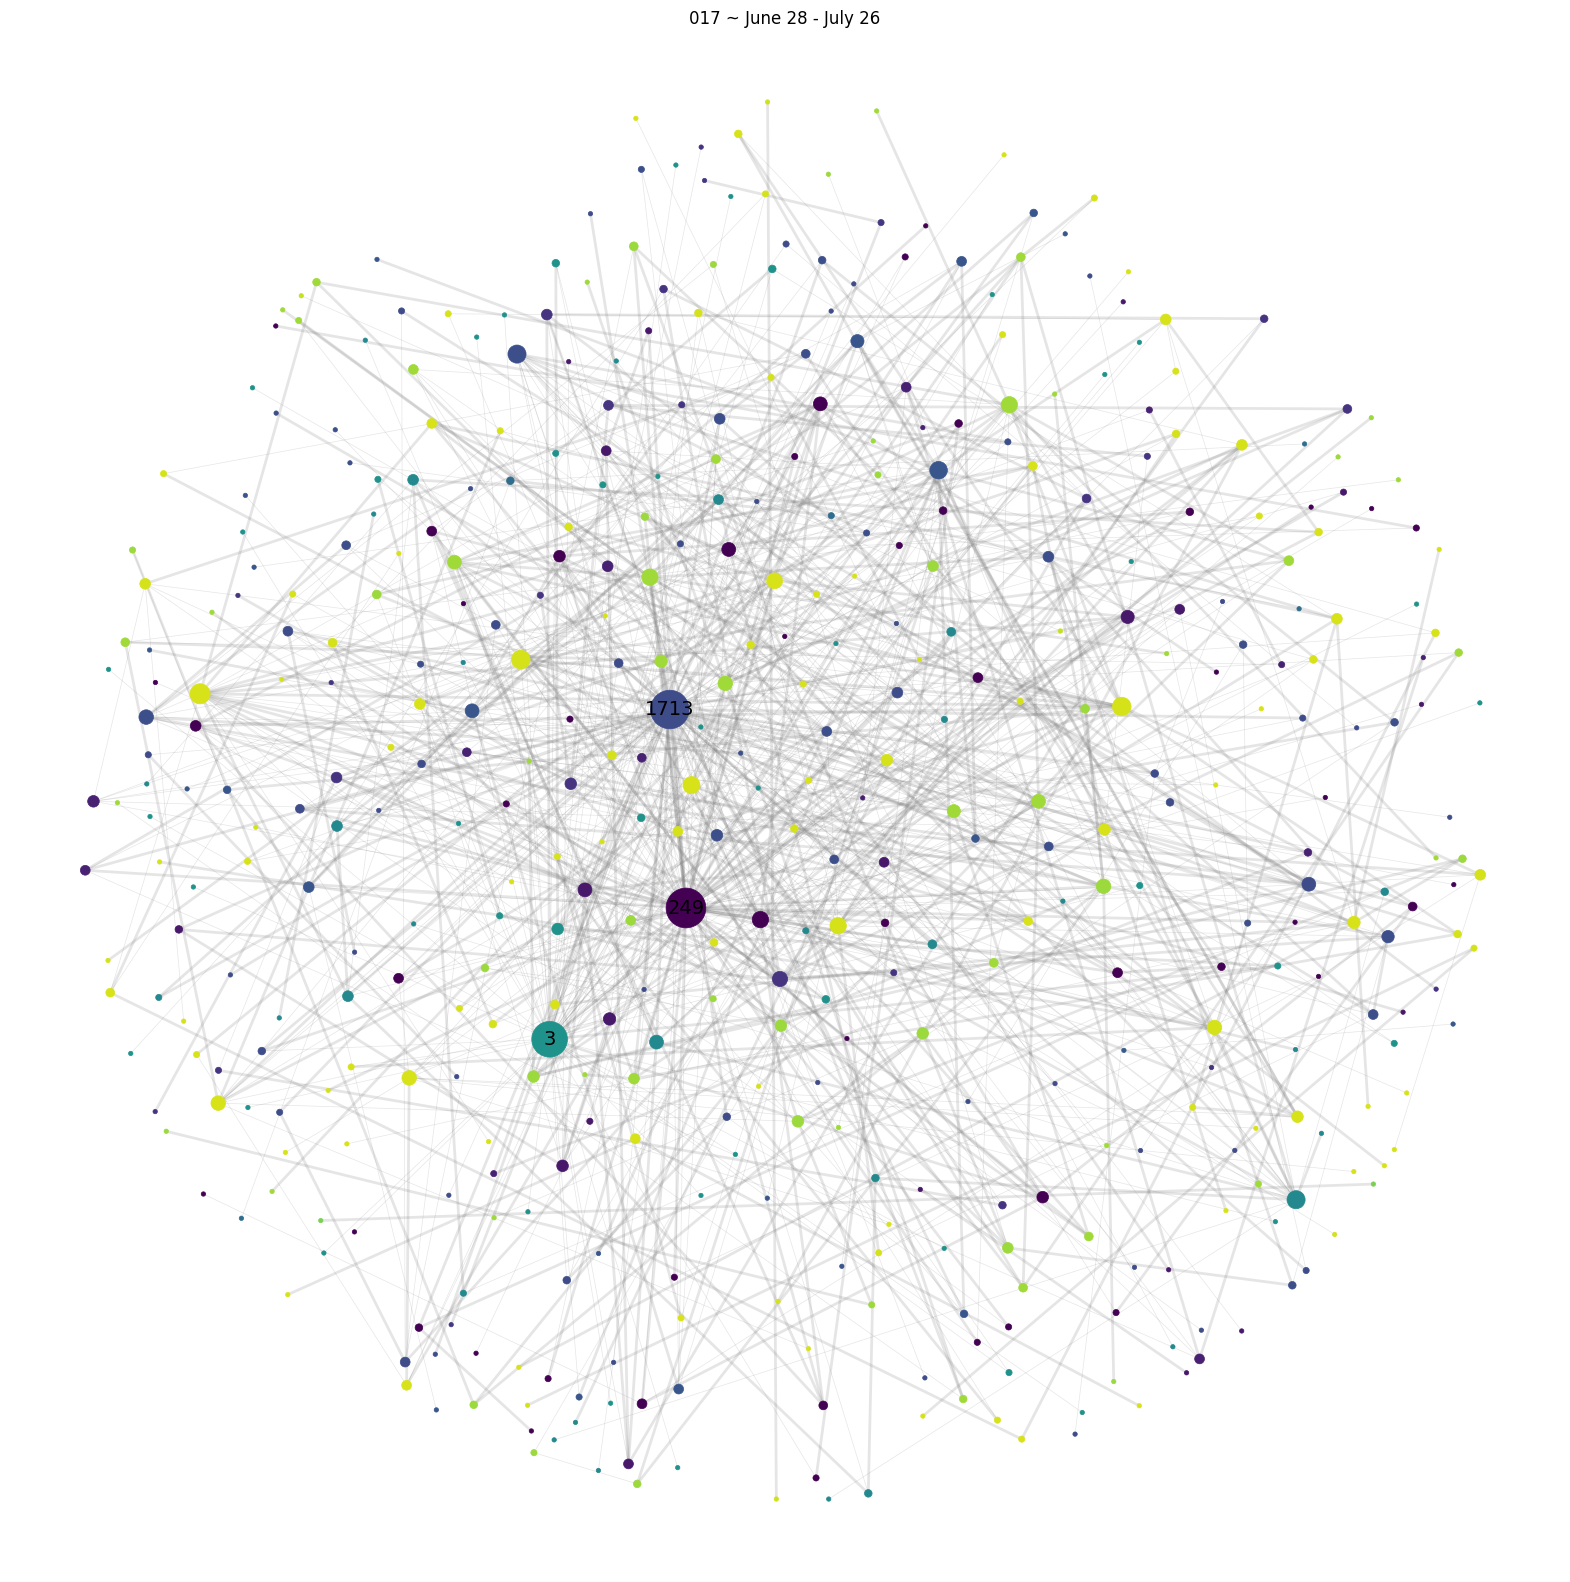

In [9]:
# variations = (
#     (7 * step, step) 
#     for step in range(1, 8)
# )
variations = [(7 * 4, 4)]

for variation in variations:
    export_time_windows_undirected(cache_layout(GRAPH_MESSAGES, nx.arf_layout), *variation)